In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import keras
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1)) / 255.0
test_images = test_images.reshape((10000, 28, 28, 1)) / 255.0

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
(train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape)

(((60000, 28, 28, 1), (60000,)), ((10000, 28, 28, 1), (10000,)))

In [4]:
def residual_block(input_data, filters, stride=1):
    x = layers.Conv2D(filters, kernel_size=(1,1), strides=(stride,stride), padding='valid')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(4*filters, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    
    if stride != 1 or input_data.shape[-1] != 4*filters:
        input_data = layers.Conv2D(4*filters, kernel_size=(1,1), strides=(stride,stride), padding='valid')(input_data)
        input_data = layers.BatchNormalization()(input_data)
        
    x = layers.add([input_data, x])
    x = layers.Activation('relu')(x)
    
    return x

In [5]:
def resnet50(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape, name='input')
    x = layers.Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
    
    x = residual_block(x, filters=64, stride=1)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='ResNet50')
    
    return model

In [8]:
model = resnet50(input_shape=(28,28,1),num_classes=10)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 64)   3200        ['input[0][0]']                  
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 14, 14, 64)  256         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 14, 14, 64)   0           ['batch_normalization_5[0]

In [9]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [10]:
model.fit(train_images,train_labels,batch_size=256,epochs=30,validation_data=(test_images, test_labels),shuffle=True)

Epoch 1/30
235/235 [==============================] - 73s 302ms/step - loss: 0.6164 - accuracy: 0.7850 - val_loss: 4.7384 - val_accuracy: 0.1435
Epoch 2/30
235/235 [==============================] - 69s 293ms/step - loss: 0.3785 - accuracy: 0.8651 - val_loss: 0.6850 - val_accuracy: 0.7562
Epoch 3/30
235/235 [==============================] - 73s 309ms/step - loss: 0.3302 - accuracy: 0.8818 - val_loss: 0.4146 - val_accuracy: 0.8446
Epoch 4/30
235/235 [==============================] - 71s 303ms/step - loss: 0.3003 - accuracy: 0.8925 - val_loss: 0.5519 - val_accuracy: 0.8098
Epoch 5/30
235/235 [==============================] - 71s 302ms/step - loss: 0.2804 - accuracy: 0.8991 - val_loss: 0.4838 - val_accuracy: 0.8309
Epoch 6/30
235/235 [==============================] - 73s 311ms/step - loss: 0.2681 - accuracy: 0.9036 - val_loss: 0.4364 - val_accuracy: 0.8363
Epoch 7/30
235/235 [==============================] - 72s 307ms/step - loss: 0.2543 - accuracy: 0.9081 - val_loss: 0.3664 - val_ac

In [12]:
scores = model.evaluate(test_images, test_labels)
scores

313/313 [==============================] - 4s 12ms/step - loss: 0.4064 - accuracy: 0.8796


[0.40635138750076294, 0.8795999884605408]

In [13]:
train_groups = [train_images[np.where(train_labels == i)[0]] for i in np.unique(train_labels)]
test_groups = [test_images[np.where(test_labels == i)[0]] for i in np.unique(train_labels)]
print("train groups:", [x.shape[0] for x in train_groups])
print("test groups:", [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [14]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [
            in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
            for c_idx in group_idx
        ]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            non_group_idx = [
                np.random.choice([i for i in all_groups if i != c_idx])
                for c_idx in group_idx
            ]
            b_group_idx = non_group_idx
            out_score += [0] * batch_halfsize
        out_img_b += [
            in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))]
            for c_idx in b_group_idx
        ]
    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)

In [16]:
upd_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output, name='FeatureExtractor')
upd_model.summary()

Model: "FeatureExtractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 14, 14, 64)   3200        ['input[0][0]']                  
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 14, 14, 64)  256         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 14, 14, 64)   0           ['batch_normalizat

In [17]:
img_a_in = layers.Input(shape=train_images.shape[1:], name="ImageA_Input")
img_b_in = layers.Input(shape=train_images.shape[1:], name="ImageB_Input")
img_a_feat = upd_model(img_a_in)
img_b_feat = upd_model(img_b_in)
combined_features = layers.concatenate([img_a_feat, img_b_feat], name="merge_features")
combined_features = layers.Dense(256, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(128, activation="linear")(combined_features)
combined_features = layers.BatchNormalization()(combined_features)
combined_features = layers.Activation("relu")(combined_features)
combined_features = layers.Dense(1, activation="sigmoid")(combined_features)
similarity_model = models.Model(
    inputs=[img_a_in, img_b_in], outputs=[combined_features], name="SimilarityModel"
)
similarity_model.summary()

Model: "SimilarityModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 FeatureExtractor (Functional)  (None, 256)          80384       ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 512)          0           ['FeatureExtractor[

In [18]:
similarity_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mae"])

1/1 [==============================] - 0s 286ms/step


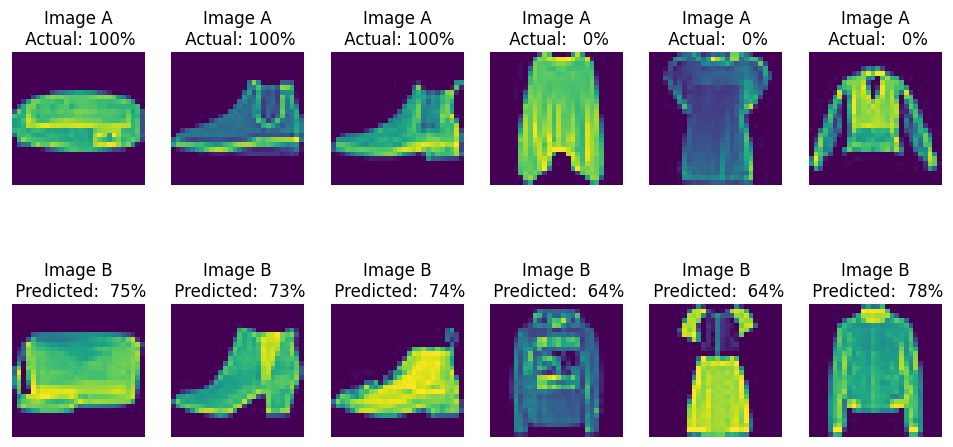

In [19]:
def log_model_result(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title("Image A\n Actual: %3.0f%%" % (100 * c_d))
        ax1.axis("off")
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title("Image B\n Predicted: %3.0f%%" % (100 * p_d))
        ax2.axis("off")
    return fig


_ = log_model_result()

In [20]:
def siam_gen(_, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size // 2)
        yield [pv_a, pv_b], pv_sim


valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True,
)

Epoch 1/10


<ipython-input-20-7a6f3930db49>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(


500/500 [==============================] - 56s 104ms/step - loss: 0.2500 - mae: 0.1603 - val_loss: 0.2575 - val_mae: 0.1503
Epoch 2/10
500/500 [==============================] - 51s 103ms/step - loss: 0.2063 - mae: 0.1268 - val_loss: 0.1998 - val_mae: 0.1280
Epoch 3/10
500/500 [==============================] - 51s 103ms/step - loss: 0.1774 - mae: 0.1091 - val_loss: 0.2665 - val_mae: 0.1458
Epoch 4/10
500/500 [==============================] - 51s 103ms/step - loss: 0.1740 - mae: 0.1050 - val_loss: 0.2266 - val_mae: 0.1252
Epoch 5/10
500/500 [==============================] - 53s 105ms/step - loss: 0.1797 - mae: 0.1089 - val_loss: 0.1936 - val_mae: 0.1210
Epoch 6/10
500/500 [==============================] - 51s 102ms/step - loss: 0.1673 - mae: 0.1023 - val_loss: 0.1756 - val_mae: 0.0996
Epoch 7/10
500/500 [==============================] - 51s 102ms/step - loss: 0.1680 - mae: 0.1016 - val_loss: 0.2410 - val_mae: 0.1274
Epoch 8/10
500/500 [==============================] - 51s 102ms/st

1/1 [==============================] - 0s 44ms/step


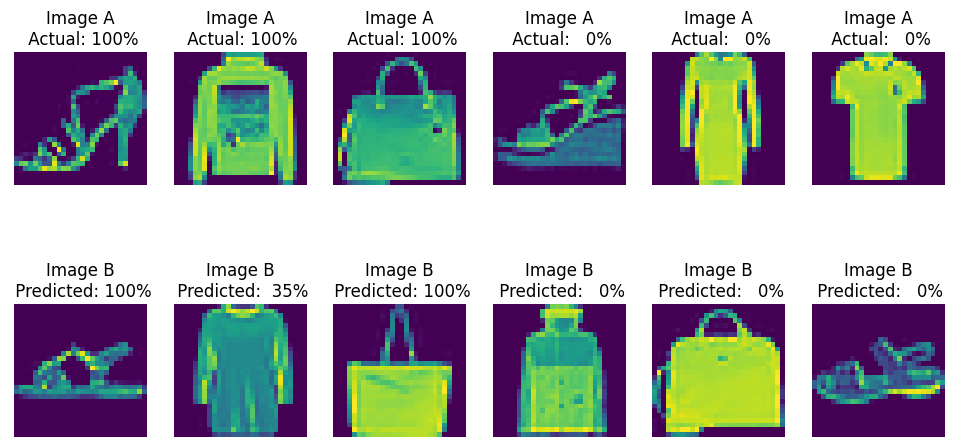

In [21]:
_ = log_model_result()

In [23]:
x_test_features = upd_model.predict(test_images, verbose=True, batch_size=256)

40/40 [==============================] - 3s 66ms/step


In [24]:
%%time
from sklearn.manifold import TSNE

tsne_obj = TSNE(
    n_components=2,
    init="pca",
    random_state=101,
    method="barnes_hut",
    n_iter=500,
    verbose=2,
)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 2.205s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.824506
[t-SNE] Computed conditional probabilities in 0.269s
[t-SNE] Iteration 50: error = 84.1285095, gradient norm = 0.0257810 (50 iterations in 4.652s)
[t-SNE] It

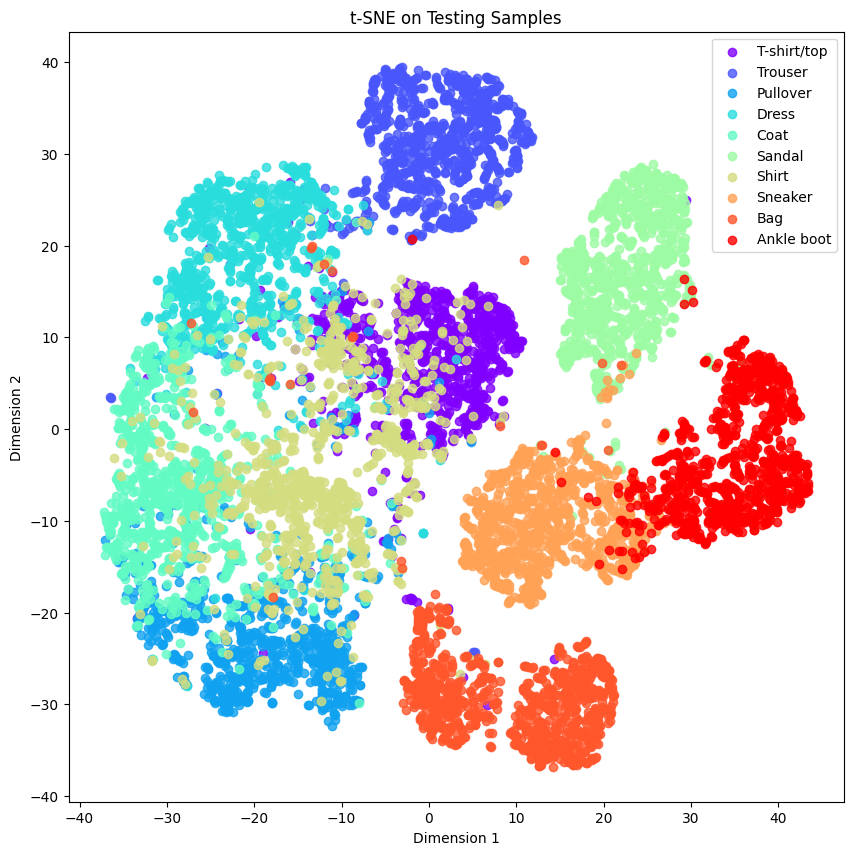

In [25]:
particular_obj_category = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, particular_obj_category)):
    plt.scatter(
        tsne_features[np.where(test_labels == c_group), 0],
        tsne_features[np.where(test_labels == c_group), 1],
        marker="o",
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label,
    )
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE on Testing Samples")
plt.legend(loc="best")
plt.show(block=False)